### Detection of fraudulent transactions in the merged fraud data

In [1]:
import shap
import mlflow
import numpy as np
import pandas as pd
import seaborn as sns
import mlflow.sklearn
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from lime.lime_tabular import LimeTabularExplainer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

c:\Users\elbet\miniconda3\envs\elbetel\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Load the data from local path
df = pd.read_csv('c:/data science/10 academy/week-8/Technical Content/Data/cleaned_data/merged_data.csv')
df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,sex,age,ip_address,class,time_diff,...,country_United States,country_Uruguay,country_Uzbekistan,country_Vanuatu,country_Venezuela,country_Viet Nam,country_Virgin Islands (U.S.),country_Yemen,country_Zambia,country_Zimbabwe
0,247547,2015-06-28 03:00:34,2015-08-09 03:57:29,47,KIXYSVCHIPQBR,0,30,1.677886e+07,0,1008.948611,...,False,False,False,False,False,False,False,False,False,False
1,220737,2015-01-28 14:21:11,2015-02-11 20:28:28,15,PKYOWQKWGJNJI,0,34,1.684205e+07,0,342.121389,...,False,False,False,False,False,False,False,False,False,False
2,390400,2015-03-19 20:49:09,2015-04-11 23:41:23,44,LVCSXLISZHVUO,1,29,1.684366e+07,0,554.870556,...,False,False,False,False,False,False,False,False,False,False
3,69592,2015-02-24 06:11:57,2015-05-23 16:40:14,55,UHAUHNXXUADJE,0,30,1.693873e+07,0,2122.471389,...,False,False,False,False,False,False,False,False,False,False
4,174987,2015-07-07 12:58:11,2015-11-03 04:04:30,51,XPGPMOHIDRMGE,0,37,1.697198e+07,0,2847.105278,...,False,False,False,False,False,False,False,False,False,False


class
0    116878
1     12268
Name: count, dtype: int64


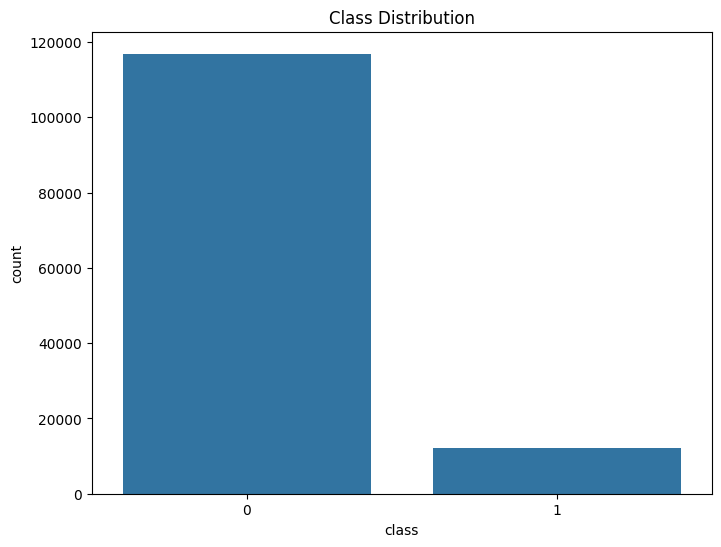

In [3]:
# Visualize Class distribution
class_counts = df['class'].value_counts()
print(class_counts)

# Visualize class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='class', data=df)
plt.title('Class Distribution')
plt.show()

In [ ]:
# Convert 'signup_time' and 'purchase_time' to datetime
df['signup_time'] = pd.to_datetime(df['signup_time'], errors='coerce')
df['purchase_time'] = pd.to_datetime(df['purchase_time'], errors='coerce')

print(df['signup_time'].isna().sum(), "NaT values in signup_time")
print(df['purchase_time'].isna().sum(), "NaT values in purchase_time")

# Feature extraction from 'signup_time' and 'purchase_time'
df['signup_year'] = df['signup_time'].dt.year
df['signup_month'] = df['signup_time'].dt.month
df['signup_day'] = df['signup_time'].dt.day
df['signup_hour'] = df['signup_time'].dt.hour

df['purchase_year'] = df['purchase_time'].dt.year
df['purchase_month'] = df['purchase_time'].dt.month
df['purchase_day'] = df['purchase_time'].dt.day
df['purchase_hour'] = df['purchase_time'].dt.hour

# Optionally drop the original datetime columns
X = df.drop(['signup_time', 'purchase_time','user_id','device_id','ip_address', 'lower_bound_ip_address', 'upper_bound_ip_address', 'class'], axis=1)
y = df['class']

0 NaT values in signup_time
0 NaT values in purchase_time


##### Using SMOTE (Synthetic Minority Over-sampling Technique) to generate synthetic data

In [13]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

X_train = X_resampled
y_train = y_resampled
class_counts = y_train.value_counts()
print(class_counts)

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

class
0    116878
1    116878
Name: count, dtype: int64


In [6]:
# Check the column names of the resampled feature matrix
display(X_train.columns)


Index(['purchase_value', 'sex', 'age', 'time_diff', 'transaction_count',
       'hour_of_day', 'day_of_week', 'purchase_value_scaled', 'source_Direct',
       'source_SEO',
       ...
       'country_Zambia', 'country_Zimbabwe', 'signup_year', 'signup_month',
       'signup_day', 'signup_hour', 'purchase_year', 'purchase_month',
       'purchase_day', 'purchase_hour'],
      dtype='object', length=202)

In [ ]:
# scaling the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#### Tracking with MLflow

In [ ]:
import os 
import joblib
# saving the models
save_folder = 'c:/data science/10 academy/week-8/Technical Content/Data/cleaned_data/fraud_detection/model/fraud_saved_models'
os.makedirs(save_folder, exist_ok=True) 

# Function to save scikit-learn models
def save_sklearn_model(model, model_name):
    save_path = os.path.join(save_folder, f'{model_name}.joblib')
    joblib.dump(model, save_path)
    print(f'{model_name} saved at {save_path}')


In [9]:
# Function to log experiments with MLflow
def log_experiment(model_name, model, X_train, X_test, y_train, y_test, params=None):
    with mlflow.start_run(run_name=model_name):
        # Fit the model
        model.fit(X_train, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        # Log parameters if provided
        if params:
            for key, value in params.items():
                mlflow.log_param(key, value)
        
        # Log metrics
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1)
        
        # Log the model
        mlflow.sklearn.log_model(model, model_name)
        
        print(f"Model: {model_name}")
        print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}")
        save_sklearn_model(model, model_name)
        print('model saved')

In [11]:
# Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_experiment("Logistic Regression", log_reg, X_train, X_test, y_train, y_test, 
               params={"max_iter": 1000})

2024/10/29 23:53:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model: Logistic Regression
Accuracy: 0.9151694045174538, Precision: 0.9235022245259384, Recall: 0.9068928950159066, F1 Score: 0.9151222017720327
Logistic Regression saved at C:/Users/elbet/OneDrive/Desktop/Ten/week8&9/github/Fraud_detection/fraud_saved_models\Logistic Regression.joblib
model saved


In [13]:
# Random Forest
rand_forest = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
log_experiment("Random Forest", rand_forest, X_train, X_test, y_train, y_test, 
               params={"n_estimators": 100, "max_depth": 10})

2024/10/24 14:33:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model: Random Forest
Accuracy: 0.8446911362080767, Precision: 0.9958662613981762, Recall: 0.6948886532343584, F1 Score: 0.8185883822610868
Random Forest saved at C:/Users/elbet/OneDrive/Desktop/Ten/week8&9/github/Fraud_detection/fraud_saved_models\Random Forest.joblib
model saved


In [14]:
# Gradient Boosting
grad_boost = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
log_experiment("Gradient Boosting", grad_boost, X_train, X_test, y_train, y_test, 
               params={"n_estimators": 100, "learning_rate": 0.1})

2024/10/24 14:35:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model: Gradient Boosting
Accuracy: 0.8935446611909651, Precision: 0.9993556009021587, Recall: 0.7893955461293743, F1 Score: 0.8820532265326919
Gradient Boosting saved at C:/Users/elbet/OneDrive/Desktop/Ten/week8&9/github/Fraud_detection/fraud_saved_models\Gradient Boosting.joblib
model saved


In [15]:
# Decision Tree
dec_tree = DecisionTreeClassifier(max_depth=5, random_state=42)
log_experiment("Decision Tree", dec_tree, X_train, X_test, y_train, y_test, 
               params={"max_depth": 5})

2024/10/24 14:35:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model: Decision Tree
Accuracy: 0.8281570841889117, Precision: 0.9999356623560445, Recall: 0.6592576882290562, F1 Score: 0.7946214019121632
Decision Tree saved at C:/Users/elbet/OneDrive/Desktop/Ten/week8&9/github/Fraud_detection/fraud_saved_models\Decision Tree.joblib
model saved


### Model Explanability using shap

In [16]:
import shap
import mlflow
import joblib
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def log_experiment_with_shap(model_name, model, X_train, X_test, y_train, y_test, params=None):
    with mlflow.start_run(run_name=model_name):
        
        # SHAP Explanation for Logistic Regression using KernelExplainer
        if model_name == "Logistic Regression":
            # Use KernelExplainer for Logistic Regression
            background = shap.sample(X_train, 100)  # Sampling a smaller set for the background
            explainer = shap.KernelExplainer(model.predict, background)
            
            # Subsample the test set to handle large data (optional for memory efficiency)
            X_test_sample = X_test[np.random.choice(X_test.shape[0], 100, replace=False)]

            # Get SHAP values
            shap_values = explainer.shap_values(X_test_sample)
            
            shap.summary_plot(shap_values, X_test_sample, plot_type="bar")

        elif model_name in ["Gradient Boosting", "Random Forest", "Decision Tree"]:
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X_test)          
            shap.summary_plot(shap_values, X_test, max_display=32)

        # Logging metrics
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        # Log parameters and metrics to MLflow
        if params:
            mlflow.log_params(params)
        mlflow.log_metric("accuracy", acc)
        mlflow.log_metric("precision", prec)
        mlflow.log_metric("recall", rec)
        mlflow.log_metric("f1_score", f1)
        
        print(f"Model: {model_name} | Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1 Score: {f1:.4f}")

100%|██████████| 100/100 [02:01<00:00,  1.21s/it]


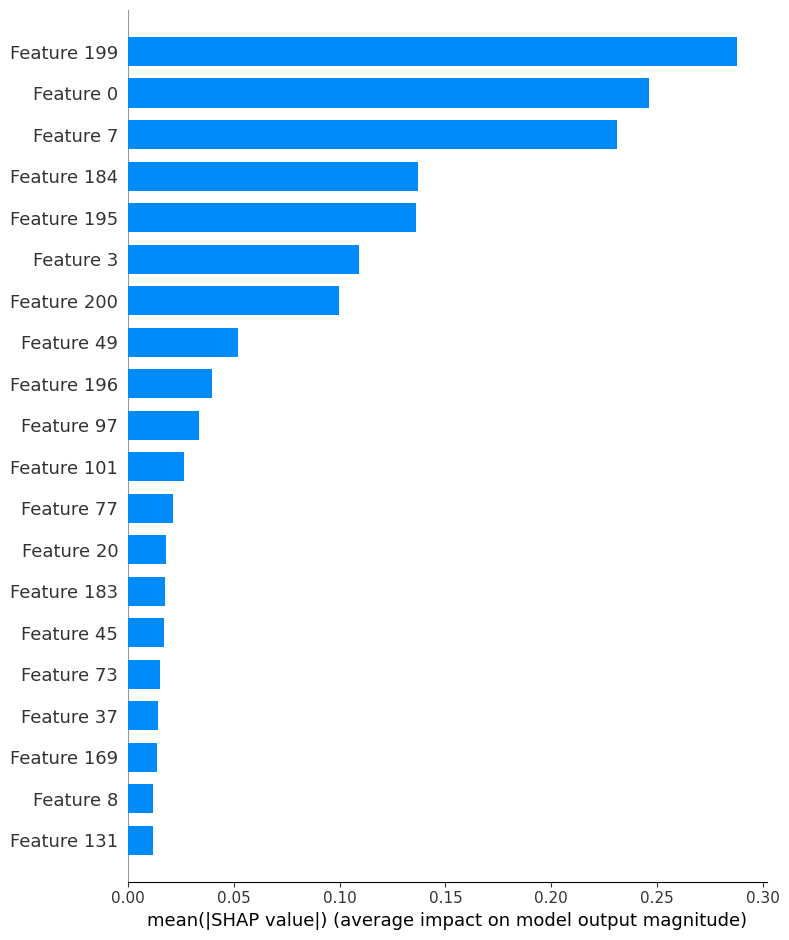

Model: Logistic Regression | Accuracy: 0.9152 | Precision: 0.9235 | Recall: 0.9069 | F1 Score: 0.9151


In [ ]:
model = joblib.load('c:/data science/10 academy/week-8/Technical Content/Data/cleaned_data/fraud_detection/model/Logistic Regression.joblib')

# Call the function with the loaded model
log_experiment_with_shap("Logistic Regression", model, X_train, X_test, y_train, y_test, params={"max_iter": 100})

##### Decision Tree

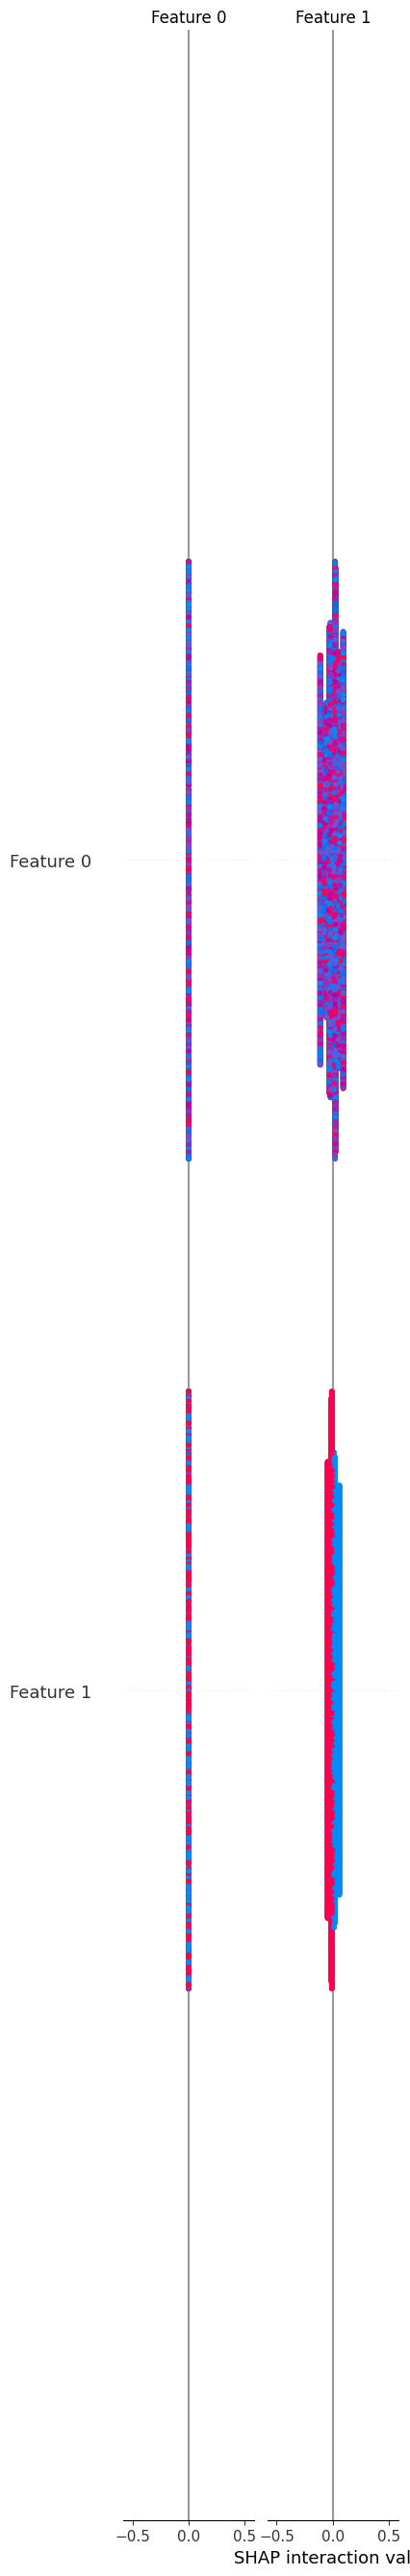

Model: Decision Tree | Accuracy: 0.8282 | Precision: 0.9999 | Recall: 0.6593 | F1 Score: 0.7946


In [ ]:
model = joblib.load('c:/data science/10 academy/week-8/Technical Content/Data/cleaned_data/fraud_detection/model/Decision Tree.joblib')
log_experiment_with_shap("Decision Tree", model, X_train, X_test, y_train, y_test, 
                         params={"max_depth": 10})


##### Random Forest

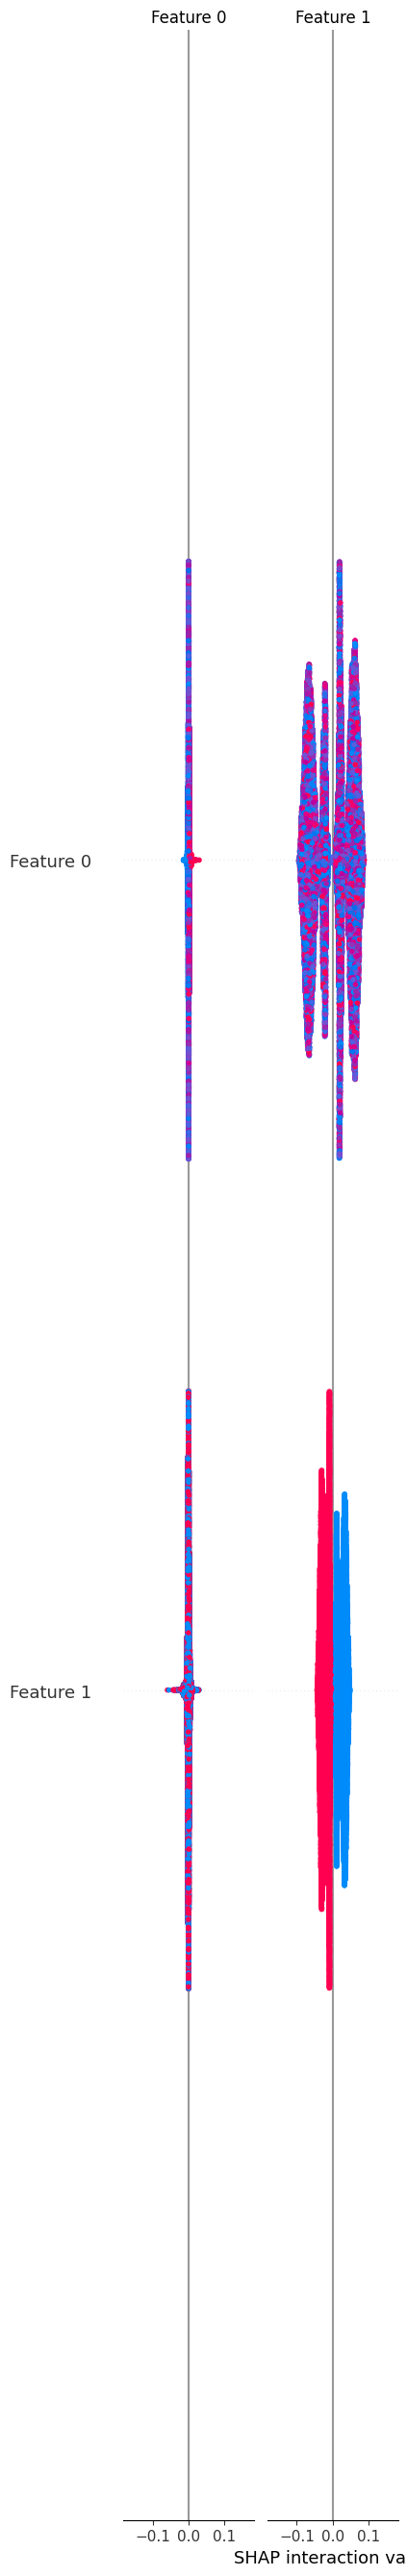

Model: Random Forest | Accuracy: 0.8447 | Precision: 0.9959 | Recall: 0.6949 | F1 Score: 0.8186


In [ ]:
model = joblib.load('c:/data science/10 academy/week-8/Technical Content/Data/cleaned_data/fraud_detection/model/Random Forest.joblib')
log_experiment_with_shap("Random Forest", model, X_train, X_test, y_train, y_test, 
                         params={"n_estimators": 100})

##### Gradient Boosting

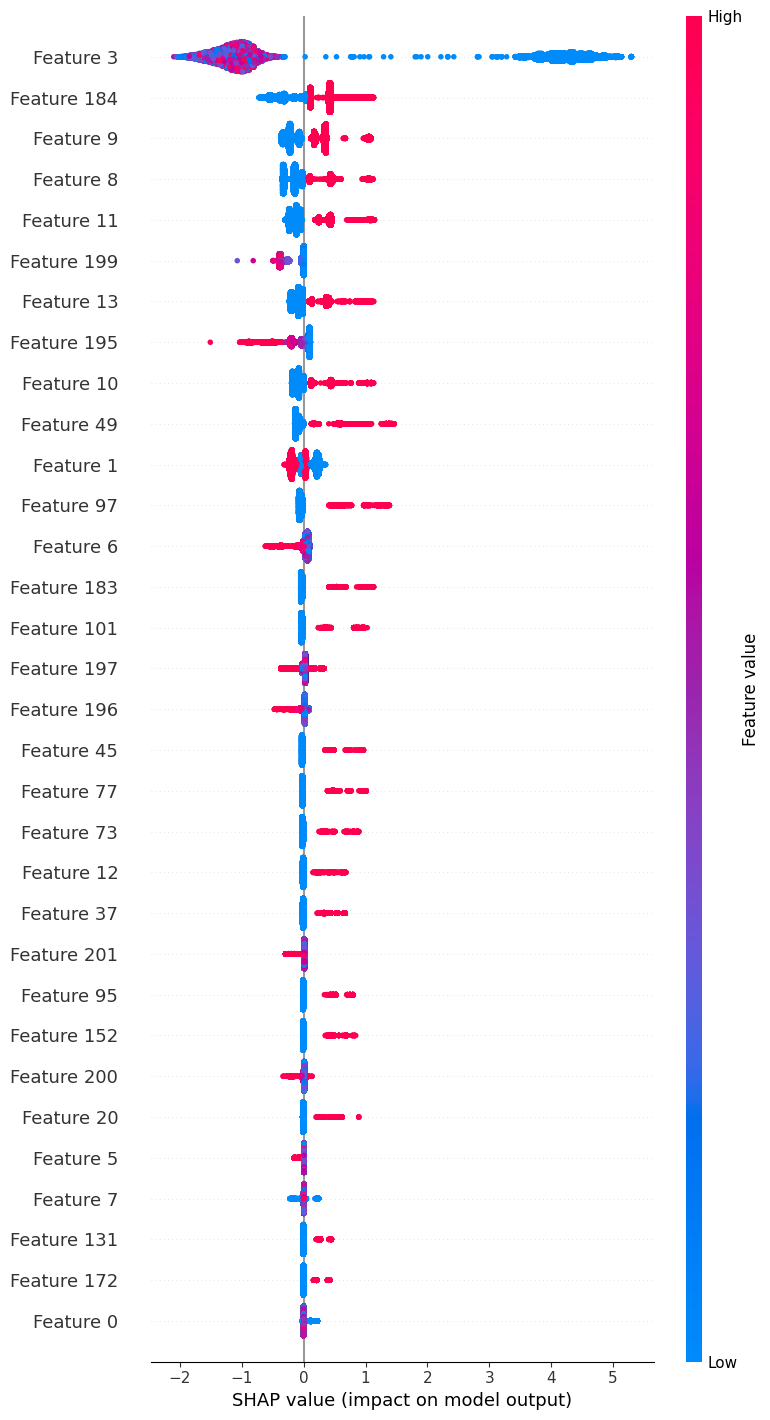

Model: Gradient Boosting | Accuracy: 0.8935 | Precision: 0.9994 | Recall: 0.7894 | F1 Score: 0.8821


In [ ]:
model = joblib.load('c:/data science/10 academy/week-8/Technical Content/Data/cleaned_data/fraud_detection/model/Gradient Boosting.joblib')
log_experiment_with_shap("Gradient Boosting", model, X_train, X_test, y_train, y_test, 
                         params={"n_estimators": 100, "learning_rate": 0.1})

### Model Explanability using Lime

In [14]:
X_train.columns.tolist() 

['purchase_value',
 'sex',
 'age',
 'time_diff',
 'transaction_count',
 'hour_of_day',
 'day_of_week',
 'purchase_value_scaled',
 'source_Direct',
 'source_SEO',
 'browser_FireFox',
 'browser_IE',
 'browser_Opera',
 'browser_Safari',
 'country_Albania',
 'country_Algeria',
 'country_Angola',
 'country_Antigua and Barbuda',
 'country_Argentina',
 'country_Armenia',
 'country_Australia',
 'country_Austria',
 'country_Azerbaijan',
 'country_Bahamas',
 'country_Bahrain',
 'country_Bangladesh',
 'country_Barbados',
 'country_Belarus',
 'country_Belgium',
 'country_Belize',
 'country_Benin',
 'country_Bermuda',
 'country_Bhutan',
 'country_Bolivia',
 'country_Bonaire; Sint Eustatius; Saba',
 'country_Bosnia and Herzegowina',
 'country_Botswana',
 'country_Brazil',
 'country_British Indian Ocean Territory',
 'country_Brunei Darussalam',
 'country_Bulgaria',
 'country_Burkina Faso',
 'country_Burundi',
 'country_Cambodia',
 'country_Cameroon',
 'country_Canada',
 'country_Cape Verde',
 'countr

In [31]:
import mlflow
import mlflow.sklearn
from lime.lime_tabular import LimeTabularExplainer
import joblib
import numpy as np
import pandas as pd

# Disable autologging for scikit-learn to avoid conflicts
mlflow.sklearn.autolog(disable=True)

def log_experiment_with_lime(model_name, model_path, X_train, X_test, y_train, y_test, sample_index=0, params=None, show_in_notebook=True):
    # Load the pre-trained model
    model = joblib.load(model_path)
    
    # Ensure X_train and X_test are handled consistently as arrays
    if isinstance(X_train, pd.DataFrame):
        feature_names = X_train.columns.tolist()  # Get actual feature names from X_train DataFrame
        X_train_values = X_train.values
    else:
        feature_names = [f'Feature_{i}' for i in range(model.n_features_in_)]  # Placeholder names
        X_train_values = X_train

    # Use all features from X_test for explanations
    if isinstance(X_test, pd.DataFrame):
        X_test_values = X_test.values  # Get all features
        instance = X_test.iloc[sample_index].values  # Use specified sample_index
    else:
        X_test_values = X_test  # Get all features as array
        instance = X_test[sample_index]  # Use specified sample_index
    
    # Start an MLflow run
    with mlflow.start_run(run_name=model_name):
        
        # Log model parameters if provided
        if params is not None:
            mlflow.log_params(params)
        
        # Log the trained model with an input example
        input_example = np.array([X_train_values[0]])  # Use first row as an example
        mlflow.sklearn.log_model(model, model_name, input_example=input_example)
        
        # Initialize the LimeTabularExplainer with actual feature names
        explainer = LimeTabularExplainer(
            training_data=X_train_values,  # Use all training features
            mode='classification', 
            feature_names=feature_names,  # Use all feature names
            class_names=np.unique(y_train).tolist(), 
            discretize_continuous=True
        )
        
        # Generate explanation for the specified instance in X_test
        exp = explainer.explain_instance(
            instance,
            model.predict_proba,
            num_features=10  # Show all features
        )
        
        # Plot the explanation using Matplotlib
        plt.figure(figsize=(10, 5))
        exp.as_pyplot_figure()
        plt.title(f'LIME Explanation for Sample {sample_index}')
        plt.show()

        # Print some information
        print(f"Model: {model_name}")


# Ensure the sample_index you want to test is consistent across different models
sample_index = 0  # Change this index as needed for different instances

##### Logistic Regression

<Figure size 1000x500 with 0 Axes>

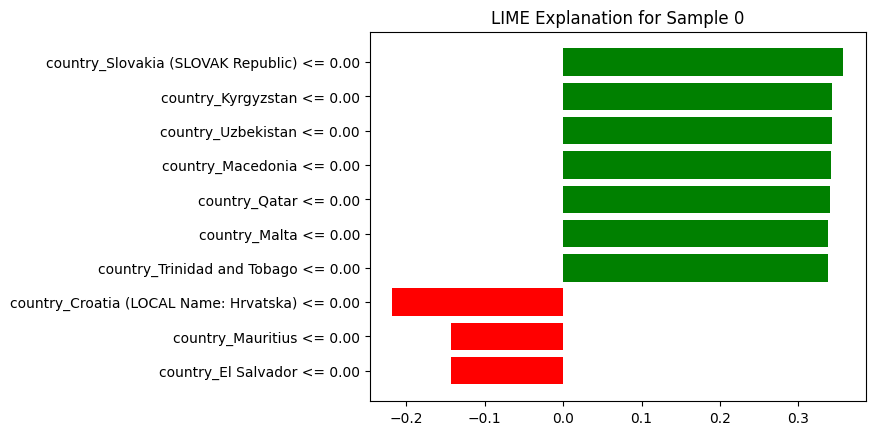

Model: Logistic Regression


In [ ]:
# Load your saved Logistic Regression model
params={"max_iter": 100}

log_experiment_with_lime(
    model_name="Logistic Regression",
    model_path='c:/data science/10 academy/week-8/Technical Content/Data/cleaned_data/fraud_detection/model/Logistic Regression.joblib',
    X_train=X_train,         
    X_test=X_test,           
    y_train=y_train,         
    y_test=y_test,
    sample_index=sample_index,           
    params=params,           
    show_in_notebook=True    
)

##### Decision Tree

<Figure size 1000x500 with 0 Axes>

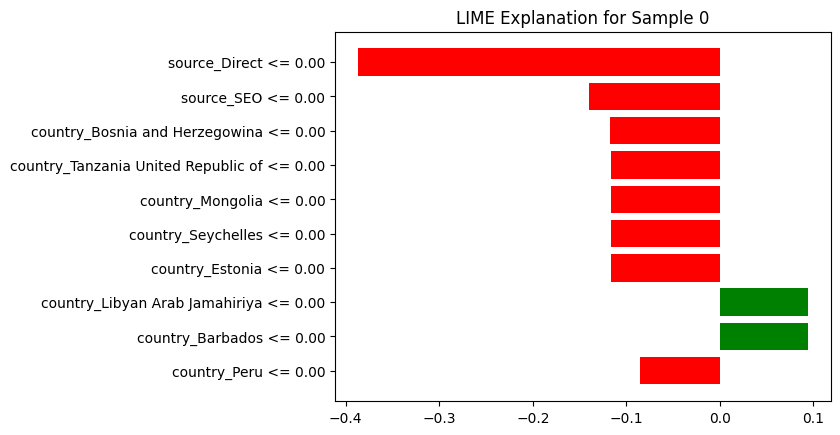

Model: Decision Tree


In [ ]:
# Load your saved Decision Tree model
params={"max_depth": 5}

log_experiment_with_lime(
    model_name="Decision Tree",
    model_path='c:/data science/10 academy/week-8/Technical Content/Data/cleaned_data/fraud_detection/model/Decision Tree.joblib',
    X_train=X_train,         
    X_test=X_test,           
    y_train=y_train,         
    y_test=y_test,
    sample_index=sample_index,           
    params=params,           
    show_in_notebook=True    
)

##### Gradient Boosting

<Figure size 1000x500 with 0 Axes>

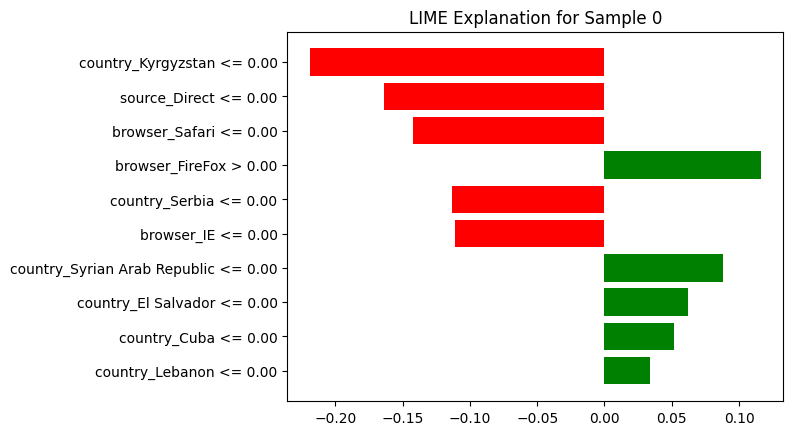

Model: Gradient_Boosting


In [ ]:
# Load your saved Gradient boosting model
params={"n_estimators": 100, "learning_rate": 0.1}

log_experiment_with_lime(
    model_name="Gradient_Boosting",
    model_path='c:/data science/10 academy/week-8/Technical Content/Data/cleaned_data/fraud_detection/model/Gradient Boosting.joblib',
    X_train=X_train,         
    X_test=X_test,           
    y_train=y_train,         
    y_test=y_test,  
    sample_index=sample_index,         
    params=params,           
    show_in_notebook=True    
)

#### Random Forest

<Figure size 1000x500 with 0 Axes>

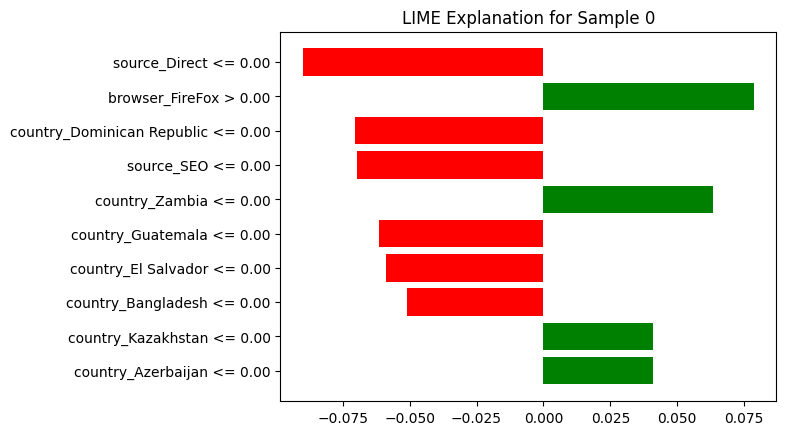

Model: Random Forest


In [ ]:
# Load your saved Gradient boosting model
params={"n_estimators": 100, "learning_rate": 0.1}

log_experiment_with_lime(
    model_name="Random Forest",
    model_path='c:/data science/10 academy/week-8/Technical Content/Data/cleaned_data/fraud_detection/model/Random Forest.joblib',
    X_train=X_train,         
    X_test=X_test,           
    y_train=y_train,         
    y_test=y_test,  
    sample_index=sample_index,         
    params=params,           
    show_in_notebook=True    
)